## Group: G15
#### Shabnam Mansurova
#### Siyu Xiao
#### Mohamed Jacer Aloui
#### Lana Kejzar

# Assignment 2.2: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or even directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size and model robustness

In [1]:
import os
import cv2 as cv 
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [2]:
class HighwayDataset(Dataset):
    """
    customized dataset, inhereted functions
    -----------
    input_dir: dir, to read images
    gt_dir: dir, to read labels from ground truth
    roi_file: range, to select valid samples
    transform: normalize and reshape images
    """
    def __init__(self, input_dir, gt_dir, roi_file, transform=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.transform = transform
        with open(roi_file, 'r') as file:
            self.roi_start, self.roi_end = map(int, file.readline().split()) # ignore the unlabeled images
        
        self.input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])[self.roi_start:self.roi_end]
        self.gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])[self.roi_start:self.roi_end]

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.input_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])
        
        img = cv.imread(img_path)[:,:,::-1].copy()  # Convert BGR to RGB and make a copy
        label = cv.imread(gt_path, 0).copy()  # Read in grayscale and make a copy
        
        # labels are given in the supplementary file
        label[label == 0] = 0       # Static Background
        label[label == 50] = 1      # Shadows
        label[label == 85] = 2      # Outside ROI
        label[label == 170] = 3     # Unknown Motion
        label[label == 255] = 4     # Motion
        
        if self.transform:
            img = self.transform(img)
            label = cv.resize(label, (img.shape[2], img.shape[1]), interpolation=cv.INTER_NEAREST)
            label = torch.tensor(label, dtype=torch.long)
        return img, label

# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 320)),  # the original size of 280 can't be fitted into cuda memory, thus resize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # preprocess -> norm
])

# instantiate dataset
dataset = HighwayDataset(
    input_dir='highway/input',
    gt_dir='highway/groundtruth',
    roi_file='highway/temporalROI.txt',
    transform=transform
)

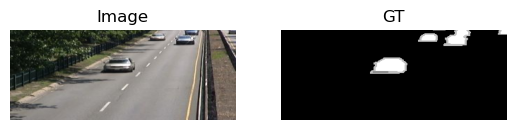

In [3]:
def show_sample():
    sample_img, sample_label = dataset[500] 
    sample_img = sample_img.permute(1, 2, 0).numpy()
    sample_img = sample_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    sample_img = sample_img.clip(0, 1)
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(sample_label, cmap="gray")
    plt.axis("off")
    plt.title("GT")
    plt.show()

show_sample()

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

In [4]:
import torch.nn as nn

In [5]:
class SegmentationModel(nn.Module):
    """
    autoencoder for segmentation task
    -----------
    num_classes: number of labels in GT
    """
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # [64, 64, 160]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # [128, 32, 80]
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # [256, 16, 40]
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # [512, 8, 20]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # [256, 16, 40]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # [128, 32, 80]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # [64, 64, 160]
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)  # [num_classes, 128, 320]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

num_classes = 5 
model = SegmentationModel(num_classes=num_classes)
print(model)

SegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(2,

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

In [6]:
from torch.utils.data import random_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score
from tqdm import tqdm

In [7]:
# splitting
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  # batch size of 4, adjust to cuda memory
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [8]:
# define model parameters
criterion = nn.CrossEntropyLoss() # for autoencoder
optimizer = optim.Adam(model.parameters(), lr=0.001) # faster training

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy()) # transfer to cpu to use numpy
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro') # for multiclass
    recall = recall_score(all_labels, all_preds, average='macro')
    iou = jaccard_score(all_labels, all_preds, average='macro')
    
    return val_loss / len(dataloader), accuracy, precision, recall, iou
    

In [16]:
"""
traing & validation loops
"""
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = [] # for visualization
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_ious = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, val_precision, val_recall, val_iou = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_ious.append(val_iou)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, IoU: {val_iou:.4f}")

    torch.cuda.empty_cache() # clear cache
print("Training complete")


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 23.40it/s]


Epoch 1/10, Train Loss: 0.2259, Val Loss: 0.0857, Accuracy: 0.9654, Precision: 0.6730, Recall: 0.5668, IoU: 0.5120


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.68it/s]


Epoch 2/10, Train Loss: 0.0641, Val Loss: 0.0548, Accuracy: 0.9774, Precision: 0.8022, Recall: 0.7516, IoU: 0.6664


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.98it/s]


Epoch 3/10, Train Loss: 0.0478, Val Loss: 0.0469, Accuracy: 0.9806, Precision: 0.8361, Recall: 0.7750, IoU: 0.6948


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.89it/s]


Epoch 4/10, Train Loss: 0.0392, Val Loss: 0.0378, Accuracy: 0.9843, Precision: 0.8658, Recall: 0.8212, IoU: 0.7485


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 25.23it/s]


Epoch 5/10, Train Loss: 0.0350, Val Loss: 0.0354, Accuracy: 0.9850, Precision: 0.8706, Recall: 0.8204, IoU: 0.7489


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.59it/s]


Epoch 6/10, Train Loss: 0.0327, Val Loss: 0.0330, Accuracy: 0.9860, Precision: 0.8719, Recall: 0.8485, IoU: 0.7723


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 25.82it/s]


Epoch 7/10, Train Loss: 0.0297, Val Loss: 0.0306, Accuracy: 0.9870, Precision: 0.8779, Recall: 0.8579, IoU: 0.7825


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 25.84it/s]


Epoch 8/10, Train Loss: 0.0275, Val Loss: 0.0291, Accuracy: 0.9877, Precision: 0.8757, Recall: 0.8775, IoU: 0.7946


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.32it/s]


Epoch 9/10, Train Loss: 0.0267, Val Loss: 0.0288, Accuracy: 0.9878, Precision: 0.8694, Recall: 0.8788, IoU: 0.7910


Validation: 100%|██████████████████████████| 62/62 [00:02<00:00, 24.64it/s]


Epoch 10/10, Train Loss: 0.0255, Val Loss: 0.0279, Accuracy: 0.9881, Precision: 0.8790, Recall: 0.8774, IoU: 0.7968
Training complete


## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model

<div style="color: red;">
Evaluation metrics for the final model: 
    <ul>
        <li>Train Loss: 0.0255</li>
        <li>Val Loss: 0.0279</li>
        <li>Accuracy: 0.9881</li>
        <li>Precision: 0.8790</li>
        <li>Recall: 0.8774</li>
        <li>IoU: 0.7968 </li>
    </ul>
</div>
<div style="color: orange;">
Performance over epochs (shown in the graphs below):
    <ul>
        <li>before epoch 4, the training loss is higher than the testing loss, indication underfitting.</li>
        <li>after epoch 4, the model starts to be stable</li>
    </ul>
</div>

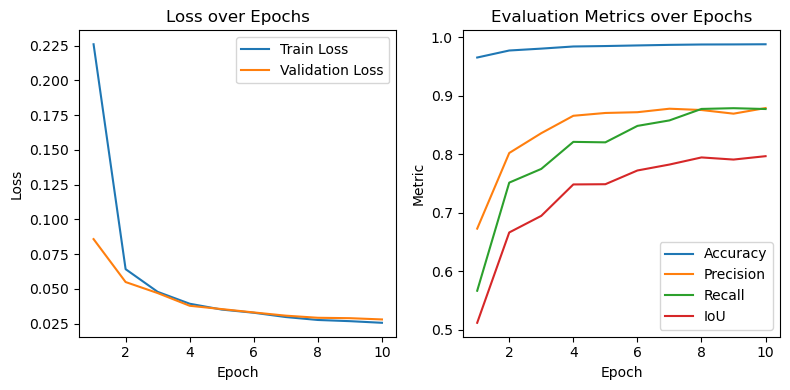

In [27]:
# 可视化训练和测试误差
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Accuracy')
plt.plot(range(1, num_epochs+1), val_precisions, label='Precision')
plt.plot(range(1, num_epochs+1), val_recalls, label='Recall')
plt.plot(range(1, num_epochs+1), val_ious, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Evaluation Metrics over Epochs')

plt.tight_layout()
plt.show()

In [30]:
def vis_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images_so_far = 0 # counter
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 8))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) # forward pass, and get the predicted class
            preds = torch.argmax(outputs, dim=1)
            
            for j in range(inputs.size()[0]): # iterate in a batch
                if images_so_far == num_images:
                    return
                images_so_far += 1
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # denormalize
                img = np.clip(img, 0, 1)
                
                label = labels[j].cpu().numpy()
                pred = preds[j].cpu().numpy()
                ax = axes[images_so_far - 1]
                
                ax[0].imshow(img)
                ax[0].set_title("Input Image")
                ax[0].axis('off')
                
                ax[1].imshow(label, cmap='gray')
                ax[1].set_title("Ground Truth")
                ax[1].axis('off')
                
                ax[2].imshow(pred, cmap='gray')
                ax[2].set_title("Prediction")
                ax[2].axis('off')      
    plt.tight_layout()
    plt.show()

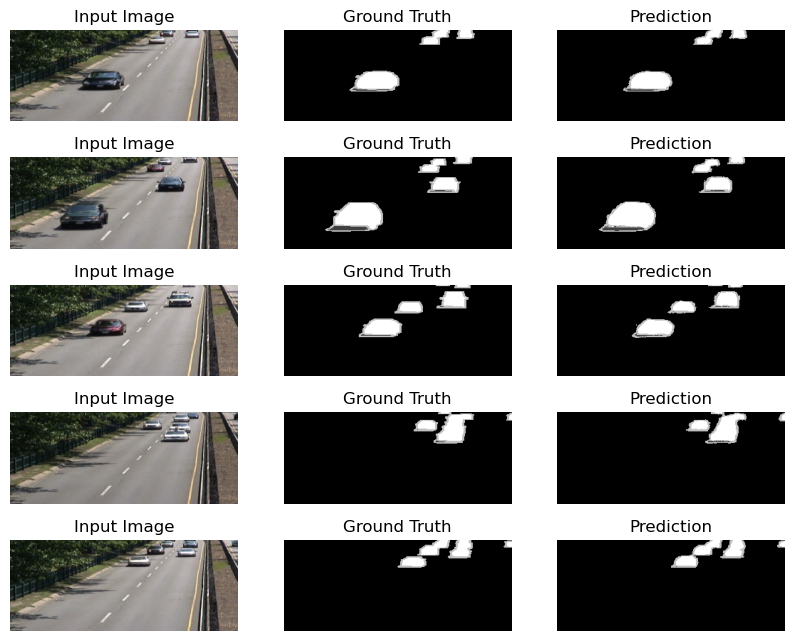

In [31]:
vis_predictions(model, train_loader, device)